## Authors: Rodrigo González Linares, and Luis Ruanova Lea

# Sentiment analysis 

## Simple transformer model

Before delving into the problem at hand, we must extract the features (texts) and labels (positive or negative) from the train set. For obvious reasons the test set only contains the features.

In [1]:
import csv
import numpy as np

xTrain = []
yTrain = []
with open('train.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        xTrain.append(row[1])
        yTrain.append(row[2])
xTrain.pop(0)
yTrain.pop(0)
yTrain = np.array([int(label) for label in yTrain ])

xTest = []
with open('test.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        xTest.append(row[1])
xTest.pop(0)

'text'

Next we need to tokenize the texts; that is mapping words and symbols (e.g. punctuation, apostrophes, etc.) to a unique numerical token.  
Before doing this though, we need to split the text into these words and symbols. To this end, we define a custom text analyzer that splits texts on blank spaces, punctuation, and numbers, number into digits, numbers and letters, and replaces words containing upper case letters for their all-lowercase version.

In [2]:
import re

def wordAnalyzer(text):

    # Split on blank spaces, punctuation, and numbers
    words = re.findall(r'\w+|[^\w\s]+', text)

    for i, word in enumerate(words):

        # Split numbers and letters (e.g. 1st --> 1 and st)
        if re.search(r'\d+\w+', word):
            match = re.search(r'(\d+)(\w+)', word)
            words[i] = match.group(1)
            words.insert(i+1, match.group(2))

        # Replace words containing uppercase letters with all-lowercase version
        if re.search(r'[A-Z]', word):
            words[i] = word.lower()

        # Split numbers into digits
        if word.isdigit():
            words[i:i+1] = list(word)

    return words

We then use this function during the creation of the tokenizer and build a vocabulary for the train set, convert the texts into numerical tokens corresponding to the vocabulary, and pad the resulting arrays with zeros so that all entries have the same length.

In [3]:
import tensorflow as tf

# Create tokenizer object
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='OOV',
                                                       analyzer=wordAnalyzer,num_words=None)

# Build vocabularies for set
tokenizer.fit_on_texts(xTrain)

# Encode inputs
xTrainEncoded = tokenizer.texts_to_sequences(xTrain) 

# Only consider the first 128 tokens
maxlen = 128 

# Pad inputs
xTrainPadded = tf.keras.utils.pad_sequences(xTrainEncoded, maxlen=maxlen, 
                                            padding='post', truncating='post')

Traditionally simple Recurrent Neural Networks (RNNs) and later Long Short-Term Memory (LSTM) networks have been used for sentiment analysis tasks. Lately however, this networks have for the most part being replaced by transformers, which tend perform better given that they process all input tokens at once, rather than sequentially.  
As such, we define a simple and very light-weight transformer, based on this implementation: https://keras.io/examples/nlp/text_classification_with_transformer/ .

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

While we did not perform any exhaustive hyperparameter tunning, we found that limiting the vocabulary size to 4,000 words, using a 16-dimensional embedding, four attention heads, and 32 feed forward hidden layers, works better than other combinations we tried.

Metal device set to: Apple M2


2023-04-19 14:30:12.781277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-19 14:30:12.781728: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


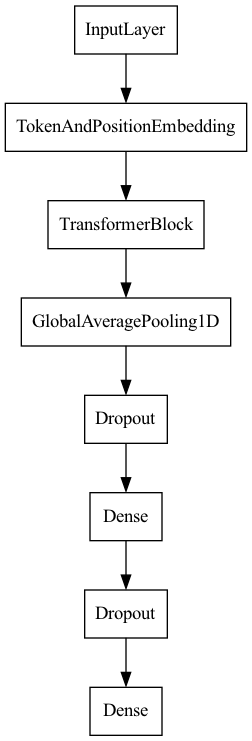

In [5]:
vocab_size = 4000  # Number of words to consider
embed_dim = 16  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_layer_names=False)

We chose to use 20% of the test data to validate the model.

In [6]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(xTrainPadded, yTrain, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20


2023-04-19 14:30:13.636614: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-19 14:30:14.191154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


76/76 [==============================] - ETA: 0s - loss: 0.6636 - accuracy: 0.6281

2023-04-19 14:30:18.117771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


76/76 [==============================] - 5s 52ms/step - loss: 0.6636 - accuracy: 0.6281 - val_loss: 0.6507 - val_accuracy: 0.6391
Epoch 2/20
76/76 [==============================] - 3s 44ms/step - loss: 0.6454 - accuracy: 0.6389 - val_loss: 0.6408 - val_accuracy: 0.6391
Epoch 3/20
76/76 [==============================] - 3s 46ms/step - loss: 0.6336 - accuracy: 0.6405 - val_loss: 0.6270 - val_accuracy: 0.6391
Epoch 4/20
76/76 [==============================] - 3s 43ms/step - loss: 0.5820 - accuracy: 0.6940 - val_loss: 0.5785 - val_accuracy: 0.6672
Epoch 5/20
76/76 [==============================] - 3s 42ms/step - loss: 0.4388 - accuracy: 0.8085 - val_loss: 0.5332 - val_accuracy: 0.7434
Epoch 6/20
76/76 [==============================] - 3s 42ms/step - loss: 0.3125 - accuracy: 0.8740 - val_loss: 0.4224 - val_accuracy: 0.7980
Epoch 7/20
76/76 [==============================] - 4s 47ms/step - loss: 0.1886 - accuracy: 0.9341 - val_loss: 0.5033 - val_accuracy: 0.7864
Epoch 8/20
76/76 [======

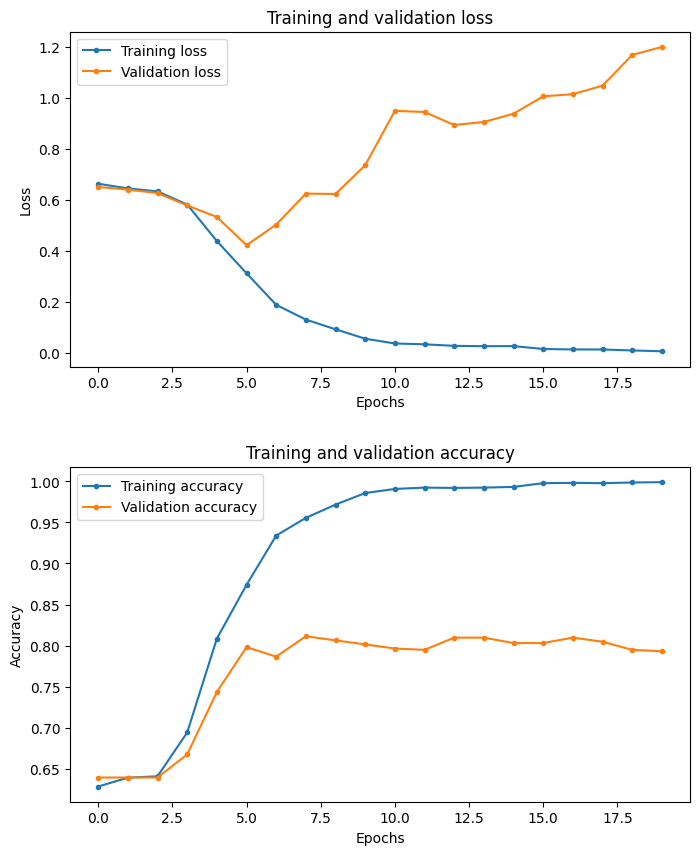

In [7]:
import matplotlib.pyplot as plt

# create a figure and axes objects
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
fig.subplots_adjust(hspace=0.3)

# plot the training and validation losses
axs[0].plot(range(len(history.history['loss'])), history.history['loss'], 'C0.-', label='Training loss')
axs[0].plot(range(len(history.history['val_loss'])), history.history['val_loss'], 'C1.-', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# plot the training and validation accuracies
axs[1].plot(range(len(history.history['accuracy'])), history.history['accuracy'], 'C0.-', label='Training accuracy')
axs[1].plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], 'C1.-', label='Validation accuracy')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# show the plot
plt.show()

Given the accuracy results on the validation set, it is clear this simple transformer model would not cut it. The model overfits when the validation test accuracy barely surpasses 80%. We will therefore resort to a tried and true transformer model.

# Fine-tunned BERT

BERT (Bidirectional Encoder Representations from Transformers) is a state-of-the-art pre-trained language model developed by Google.  
In particular we are going to use a version called DistilBERT uncased, this version has 40% less parameters than the standard BERT, and works with uncapitalized texts.  
This model is available on Hugginface's transformers library.  
For tokenization, the library works with lists instead of arrays, and we therefore need to process the texts a bit differently as follows:

In [2]:
from datasets import Dataset

# Define the generator function
def gen():
    for i in range(len(xTrain)):
        yield {"text": xTrain[i], "label": yTrain[i]}

# Create the dataset
dsTrain = Dataset.from_generator(gen)

Found cached dataset generator (/home/mia2/.cache/huggingface/datasets/generator/default-2292c0b8c7892819/0.0.0)


Next we import DistilBERT's tokenizer, apply it to the texts, and pad.

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [4]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [5]:
tokenizedDsTrain = dsTrain.map(preprocess_function, batched=True)

Loading cached processed dataset at /home/mia2/.cache/huggingface/datasets/generator/default-2292c0b8c7892819/0.0.0/cache-df8638082642c1d6.arrow


In [6]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

Next we define accuracy as the metric to evaluate, and create an optimizer for fine-tunning.

In [9]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [10]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenizedDsTrain) // batch_size 
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

After that is done we import the pre-trained distilBERT uncased model from Huggingface specifying the number of labels to use (2 in our case; positive and negative).

In [11]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)

2023-04-19 18:03:56.224601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-19 18:03:56.239620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-19 18:03:56.241152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-19 18:03:56.242977: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Then we prepare the sets. As before, we keep 80% of the original train set for fine-tunning, while we use the remaining 20% for validating the model.

In [12]:
tf_train_set = model.prepare_tf_dataset(tokenizedDsTrain, shuffle=True, 
                                        batch_size=16, collate_fn=data_collator)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [13]:
shuffled_dataset = tf_train_set.shuffle(buffer_size=10)

tf_validation_set = tf_train_set.take(int(len(tf_train_set)*0.2)) 
tf_train_set = tf_train_set.skip(int(len(tf_train_set)*0.2))

Once that is done, we prepare and fine-tune the model.

In [15]:
import tensorflow as tf

model.compile(optimizer=optimizer, metrics=['accuracy'])

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [16]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [17]:
history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=5, callbacks=metric_callback)

Epoch 1/5
151/151 [==============================] - 11s 45ms/step - loss: 0.4138 - accuracy: 0.9071 - val_loss: 0.2028 - val_accuracy: 0.9189
Epoch 2/5
151/151 [==============================] - 5s 32ms/step - loss: 0.1969 - accuracy: 0.9780 - val_loss: 0.1191 - val_accuracy: 0.9645
Epoch 3/5
151/151 [==============================] - 5s 32ms/step - loss: 0.1054 - accuracy: 0.9916 - val_loss: 0.0458 - val_accuracy: 0.9865
Epoch 4/5
151/151 [==============================] - 5s 32ms/step - loss: 0.0627 - accuracy: 0.9899 - val_loss: 0.0185 - val_accuracy: 0.9966
Epoch 5/5
151/151 [==============================] - 5s 33ms/step - loss: 0.0406 - accuracy: 0.9966 - val_loss: 0.0141 - val_accuracy: 0.9983


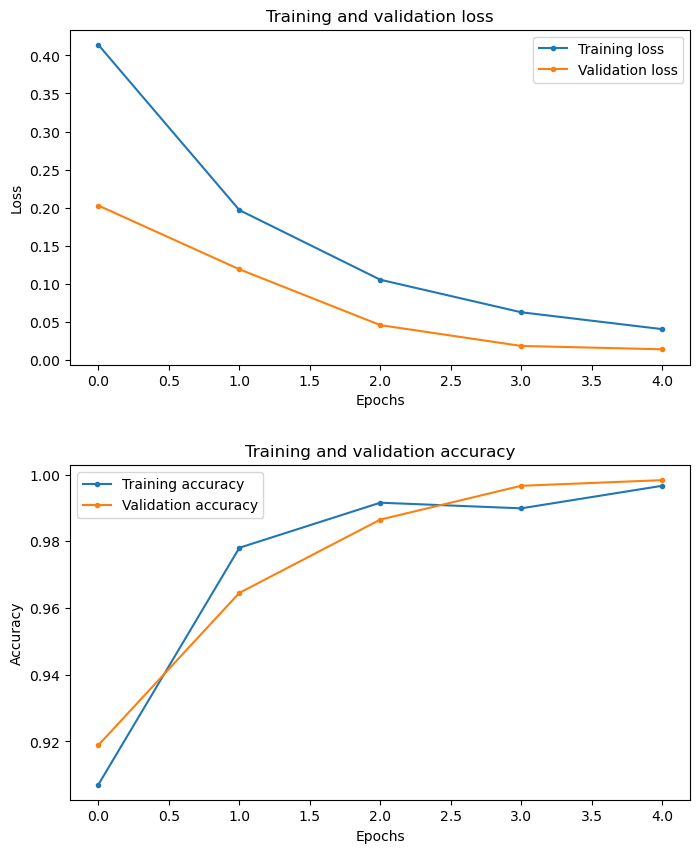

In [18]:
import matplotlib.pyplot as plt

# create a figure and axes objects
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
fig.subplots_adjust(hspace=0.3)

# plot the training and validation losses
axs[0].plot(range(len(history.history['loss'])), history.history['loss'], 'C0.-', label='Training loss')
axs[0].plot(range(len(history.history['val_loss'])), history.history['val_loss'], 'C1.-', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# plot the training and validation accuracies
axs[1].plot(range(len(history.history['accuracy'])), history.history['accuracy'], 'C0.-', label='Training accuracy')
axs[1].plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], 'C1.-', label='Validation accuracy')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# show the plot
plt.show()

A clear improvement in performance can be seen when contrasted with the simple transformed model; we will then save it. 

In [19]:
model.save_weights('finetunned-distilbert-base-uncased.h5')

Next we evaluate a couple of examples just to see how much better this fine-tunned model is over the non-fine-tuned distilBERT. The text clearly represent positive emotions.  

In [20]:
text = xTest[4]
print(text)

i highly recommend this camera to anyone looking for a good digital camera that takes great pictures yet does n ' t take weeks to figure out how to operate


In [21]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased")
classifier(text)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_39', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

[{'label': 'LABEL_1', 'score': 0.5003793835639954}]

In [22]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
classifier(text)

[{'label': 'LABEL_1', 'score': 0.9978162050247192}]

The non-fined-tunned model correctly classified the text as positive (1), but it was not very confident about its decision (i.e. the score is far from 1). The fine-tunned model on the other hand also correctly classified it as positive (1), but it did so with a high degree of certainty (as it got a score close to 1).  
Next we do the same with a text that represents negative emotions.

In [23]:
text = xTest[8]
print(text)

however , the ipod does not come close to the number of extra features that the ' zen micro ' has to offer


In [24]:
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased")
classifier(text)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_59', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

[{'label': 'LABEL_1', 'score': 0.5098509788513184}]

In [25]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
classifier(text)

[{'label': 'LABEL_0', 'score': 0.9931193590164185}]

Now the non-fined-tunned model misclassified the text as positive (1), while the fine-tunned one classified it correctly as negative (0).  
As the model seems to be performing well, we will process the whole test set with it.

In [26]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
predictions = classifier(xTest)

Finally we will change 'LABEL_0' for 0, and 'LABEL_1' for 1, and create a JSON file in the specified format for delivery.

In [27]:
predictionLabels = []
for prediction in predictions:
    if prediction['label'] == 'LABEL_0':
        predictionLabels.append(0)
    else:
        predictionLabels.append(1)

In [28]:
import json

# create a dictionary with the index as string keys
predictionDictionary = {"target": {str(idx): val for idx, val in enumerate(predictionLabels)}}

# write the dictionary to a JSON file
with open("predictions.json", "w") as f:
    json.dump(predictionDictionary, f)